In [1]:
# trzeba naprawić jak nie ma False positive or negative

def evaluateBinaryClassification(predictions, actuals):
    contigency = pd.crosstab(actuals, predictions)
    if len(contigency.columns) == 1:
        contigency[1][0] = 0
        contigency[0][1] = 0
    print(contigency)
    TP = contigency[1][1]
    TN = contigency[0][0]
    FP = contigency[1][0]
    FN = contigency[0][1]
    n = contigency.sum().sum()

    Acuracy = (TP + TN)/n
    Recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    FScore = 2*Recall*Precision/(Recall+Precision)

    return Acuracy, Recall, Precision, FScore

In [3]:
import pandas as pd

X_train = pd.read_csv("train_gaussian.csv", index_col=0)
y_train = X_train["depression"]
X_train.drop("depression", axis=1, inplace=True)

X_test = pd.read_csv("test_gaussian.csv", index_col=0)
y_test = X_test["depression"]
X_test.drop("depression", axis=1, inplace=True)

In [4]:
for i in range(len(X_train.columns)):
    minn = X_train.iloc[:, i].min()
    maxx = X_train.iloc[:, i].max()
    meann = X_train.iloc[:, i].mean()
    for j in range(len(X_train)):
        X_train.iloc[j, i] = (X_train.iloc[j, i] - meann)/(maxx-minn)
    for j in range(len(X_test)):
        X_test.iloc[j, i] = (X_test.iloc[j, i] - meann)/(maxx-minn)

In [12]:
print(y_test)

7983     0
10400    1
15872    1
8343     1
10930    0
        ..
17347    1
17063    0
28638    0
10823    1
13311    0
Name: depression, Length: 8653, dtype: int64


In [ ]:
import tensorflow as tf
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(258, input_dim=129, activation='leaky_relu'))
	model.add(Dense(2, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
	return model

In [5]:
# multi-class classification with Keras
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

In [ ]:
print(dummy_y)

In [ ]:

estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=16, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, dummy_y, cv=kfold, verbose=3)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [11]:
import tensorflow as tf
import datetime
import numpy as np
from sklearn.utils import class_weight
# for i in range():
model = Sequential()
model.add(Dense(84, input_dim=42, activation='relu'))
model.add(Dense(21, input_dim=84, activation='relu'))
model.add(Dense(10, input_dim=21, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
    tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(),
])
model.summary()

class_weights = class_weight.compute_class_weight('balanced',classes=y_train.unique(), y = y_train)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=X_train, y=y_train, epochs=30, 
batch_size=13, verbose=1, class_weight=class_weights,
validation_data=(X_test, y_test), 
    callbacks=[tensorboard_callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 84)                3612      
                                                                 
 dense_21 (Dense)            (None, 21)                1785      
                                                                 
 dense_22 (Dense)            (None, 10)                220       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,628
Trainable params: 5,628
Non-trainable params: 0
_________________________________________________________________


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
import numpy as np

neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 25381
    Positive: 2236 (8.81% of total)



In [26]:
from tensorflow import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential()
    model.add(Dense(242, activation='relu',input_dim=121))
    model.add(keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(1, activation='sigmoid',
                        bias_initializer=output_bias))
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)

    return model

In [30]:
EPOCHS = 100
BATCH_SIZE = 25

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

In [31]:
model = make_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 242)               29524     
                                                                 
 dropout_8 (Dropout)         (None, 242)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 243       
                                                                 
Total params: 29,767
Trainable params: 29,767
Non-trainable params: 0
_________________________________________________________________


In [32]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

1016/1016 [==============================] - 7s 7ms/step - loss: 1.9079 - tp: 4215.0000 - fp: 45677.0000 - tn: 613.0000 - fn: 257.0000 - accuracy: 0.0951 - precision: 0.0845 - recall: 0.9425 - auc: 0.4634 - prc: 0.0901
Loss: 1.9079


In [33]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.33709022])

In [34]:
model = make_model(output_bias=initial_bias)
model.predict(X_train)
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

1016/1016 [==============================] - 7s 7ms/step - loss: 0.2996 - tp: 4215.0000 - fp: 45677.0000 - tn: 23758.0000 - fn: 2493.0000 - accuracy: 0.3674 - precision: 0.0845 - recall: 0.6284 - auc: 0.4831 - prc: 0.0894
Loss: 0.2996


In [35]:
import os
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [36]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/20
1016/1016 [==============================] - 12s 11ms/step - loss: 0.2508 - tp: 4523.0000 - fp: 45962.0000 - tn: 46618.0000 - fn: 4421.0000 - accuracy: 0.5037 - precision: 0.0896 - recall: 0.5057 - auc: 0.5397 - prc: 0.0954 - val_loss: 0.2285 - val_tp: 101.0000 - val_fp: 66.0000 - val_tn: 9880.0000 - val_fn: 831.0000 - val_accuracy: 0.9175 - val_precision: 0.6048 - val_recall: 0.1084 - val_auc: 0.8276 - val_prc: 0.3766
Epoch 2/20
1016/1016 [==============================] - 10s 10ms/step - loss: 0.2308 - tp: 410.0000 - fp: 237.0000 - tn: 22908.0000 - fn: 1826.0000 - accuracy: 0.9187 - precision: 0.6337 - recall: 0.1834 - auc: 0.8281 - prc: 0.3983 - val_loss: 0.2273 - val_tp: 144.0000 - val_fp: 107.0000 - val_tn: 9839.0000 - val_fn: 788.0000 - val_accuracy: 0.9177 - val_precision: 0.5737 - val_recall: 0.1545 - val_auc: 0.8289 - val_prc: 0.3845
Epoch 3/20
1016/1016 [==============================] - 10s 10ms/step - loss: 0.2260 - tp: 433.0000 - fp: 229.0000 - tn: 22916.0000 - 

In [37]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/20
1016/1016 [==============================] - 12s 11ms/step - loss: 0.2410 - tp: 518.0000 - fp: 464.0000 - tn: 32627.0000 - fn: 2650.0000 - accuracy: 0.9141 - precision: 0.5275 - recall: 0.1635 - auc: 0.8060 - prc: 0.3416 - val_loss: 0.2278 - val_tp: 119.0000 - val_fp: 78.0000 - val_tn: 9868.0000 - val_fn: 813.0000 - val_accuracy: 0.9181 - val_precision: 0.6041 - val_recall: 0.1277 - val_auc: 0.8294 - val_prc: 0.3823
Epoch 2/20
1016/1016 [==============================] - 10s 10ms/step - loss: 0.2295 - tp: 392.0000 - fp: 265.0000 - tn: 22880.0000 - fn: 1844.0000 - accuracy: 0.9169 - precision: 0.5967 - recall: 0.1753 - auc: 0.8326 - prc: 0.3983 - val_loss: 0.2278 - val_tp: 127.0000 - val_fp: 88.0000 - val_tn: 9858.0000 - val_fn: 805.0000 - val_accuracy: 0.9179 - val_precision: 0.5907 - val_recall: 0.1363 - val_auc: 0.8281 - val_prc: 0.3848
Epoch 3/20
1016/1016 [==============================] - 10s 10ms/step - loss: 0.2259 - tp: 432.0000 - fp: 254.0000 - tn: 22891.0000 - fn: 

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors[0])

#1f77b4


In [39]:


def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

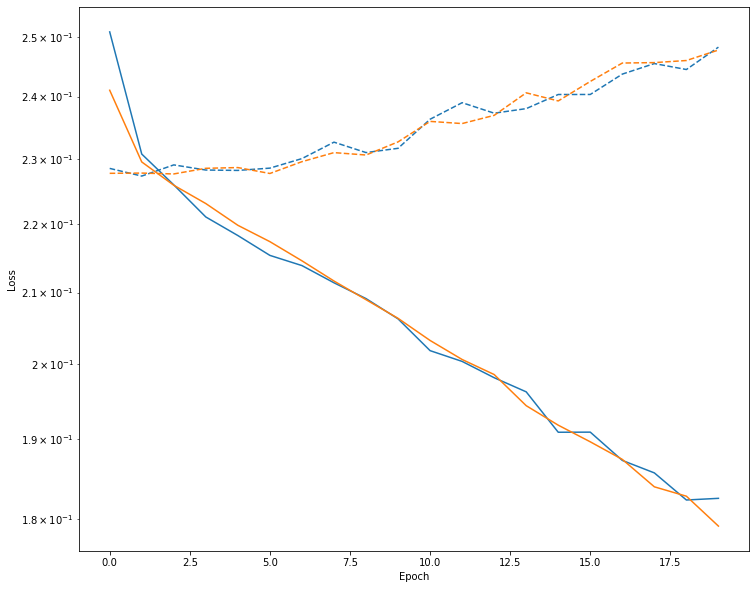

In [40]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [41]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test))

Epoch 1/100
1016/1016 [==============================] - 12s 11ms/step - loss: 0.2415 - tp: 479.0000 - fp: 403.0000 - tn: 32688.0000 - fn: 2689.0000 - accuracy: 0.9147 - precision: 0.5431 - recall: 0.1512 - auc: 0.8034 - prc: 0.3415 - val_loss: 0.2284 - val_tp: 107.0000 - val_fp: 60.0000 - val_tn: 9886.0000 - val_fn: 825.0000 - val_accuracy: 0.9186 - val_precision: 0.6407 - val_recall: 0.1148 - val_auc: 0.8294 - val_prc: 0.3811
Epoch 2/100
1016/1016 [==============================] - 10s 10ms/step - loss: 0.2298 - tp: 381.0000 - fp: 247.0000 - tn: 22898.0000 - fn: 1855.0000 - accuracy: 0.9172 - precision: 0.6067 - recall: 0.1704 - auc: 0.8323 - prc: 0.3964 - val_loss: 0.2276 - val_tp: 126.0000 - val_fp: 73.0000 - val_tn: 9873.0000 - val_fn: 806.0000 - val_accuracy: 0.9192 - val_precision: 0.6332 - val_recall: 0.1352 - val_auc: 0.8278 - val_prc: 0.3833
Epoch 3/100
1016/1016 [==============================] - 10s 10ms/step - loss: 0.2250 - tp: 403.0000 - fp: 252.0000 - tn: 22893.0000 - f

In [42]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

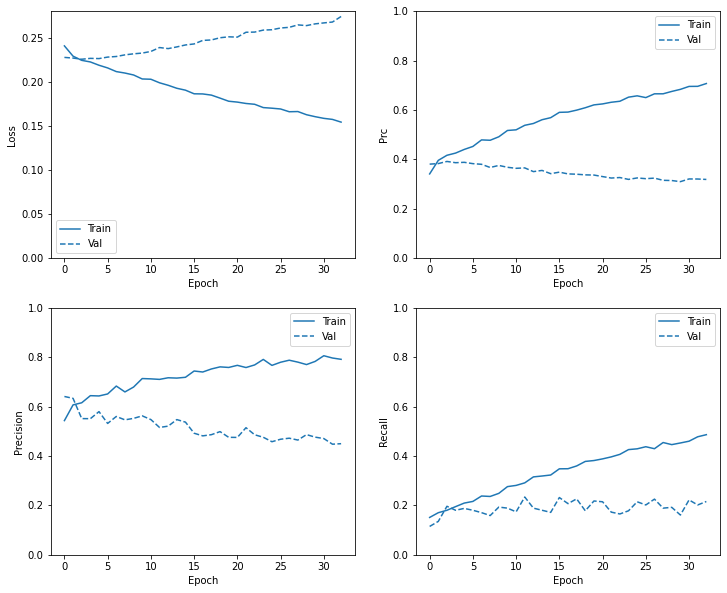

In [43]:
plot_metrics(baseline_history)

In [44]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

436/436 [==============================] - 0s 909us/step


In [45]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.22629433870315552
tp :  183.0
fp :  149.0
tn :  9797.0
fn :  749.0
accuracy :  0.9174480438232422
precision :  0.5512048006057739
recall :  0.19635193049907684
auc :  0.8326985239982605
prc :  0.3919447660446167

Legitimate Transactions Detected (True Negatives):  9797
Legitimate Transactions Incorrectly Detected (False Positives):  149
Fraudulent Transactions Missed (False Negatives):  749
Fraudulent Transactions Detected (True Positives):  183
Total Fraudulent Transactions:  932


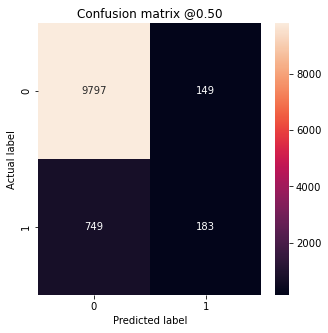

In [46]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [47]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

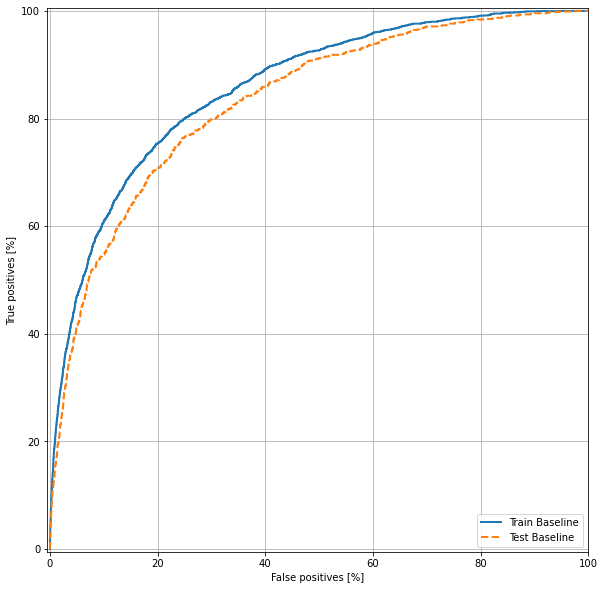

In [48]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right');

In [49]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

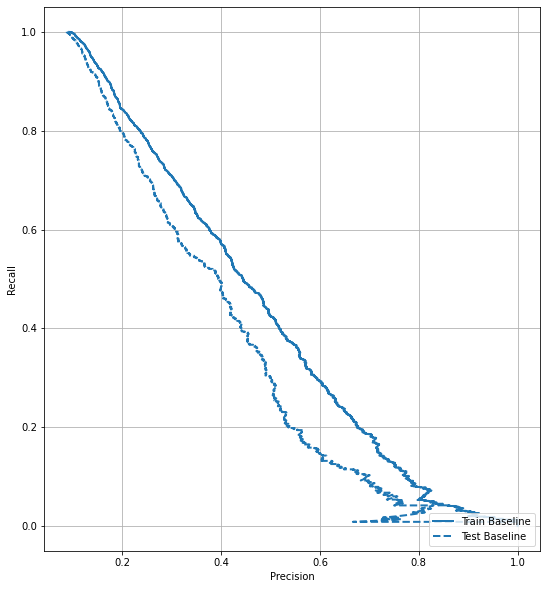

In [50]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [80]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(neg)
print(pos)

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

23145
2236
Weight for class 0: 0.55
Weight for class 1: 5.68


In [81]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
1016/1016 [==============================] - 12s 11ms/step - loss: 0.5658 - tp: 1921.0000 - fp: 5655.0000 - tn: 27436.0000 - fn: 1247.0000 - accuracy: 0.8096 - precision: 0.2536 - recall: 0.6064 - auc: 0.7962 - prc: 0.3354 - val_loss: 0.5377 - val_tp: 688.0000 - val_fp: 2393.0000 - val_tn: 7553.0000 - val_fn: 244.0000 - val_accuracy: 0.7576 - val_precision: 0.2233 - val_recall: 0.7382 - val_auc: 0.8279 - val_prc: 0.3769
Epoch 2/100
1016/1016 [==============================] - 10s 9ms/step - loss: 0.5142 - tp: 1585.0000 - fp: 5017.0000 - tn: 18128.0000 - fn: 651.0000 - accuracy: 0.7767 - precision: 0.2401 - recall: 0.7089 - auc: 0.8265 - prc: 0.3742 - val_loss: 0.4985 - val_tp: 662.0000 - val_fp: 2112.0000 - val_tn: 7834.0000 - val_fn: 270.0000 - val_accuracy: 0.7810 - val_precision: 0.2386 - val_recall: 0.7103 - val_auc: 0.8289 - val_prc: 0.3849
Epoch 3/100
1016/1016 [==============================] - 10s 9ms/step - loss: 0.4985 - tp: 1639.0000 - fp: 4933.0000 - tn: 18212.0

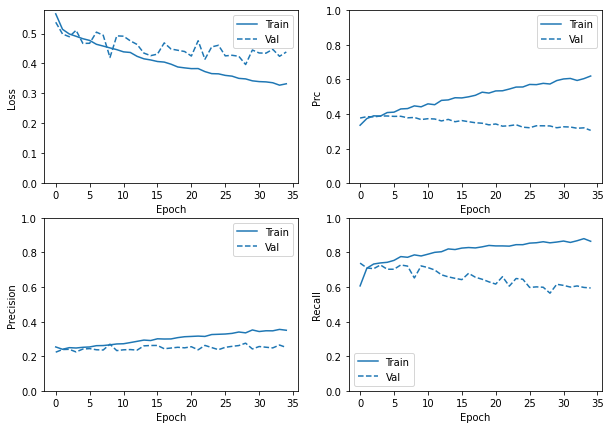

In [82]:
plot_metrics(weighted_history)

In [83]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

436/436 [==============================] - 0s 879us/step


loss :  0.46719738841056824
tp :  655.0
fp :  2058.0
tn :  7888.0
fn :  277.0
accuracy :  0.7853465676307678
precision :  0.2414301484823227
recall :  0.7027897238731384
auc :  0.8300950527191162
prc :  0.38884788751602173

Legitimate Transactions Detected (True Negatives):  7888
Legitimate Transactions Incorrectly Detected (False Positives):  2058
Fraudulent Transactions Missed (False Negatives):  277
Fraudulent Transactions Detected (True Positives):  655
Total Fraudulent Transactions:  932


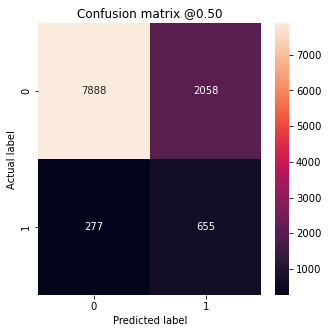

In [84]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

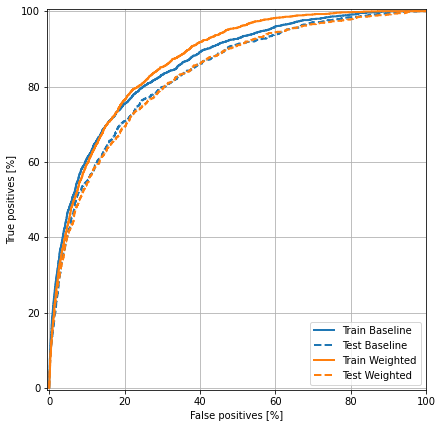

In [74]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [88]:
import shap
plt.rcParams['figure.figsize'] = [10, 7]

features = list(X_train.columns)
print(features)

['asthma_relative_0.0', 'walking_equipment_1.0', 'moderate_work_1.0', 'asthma_currently_1.0', 'health_problem_Back or Neck_1.0', 'health_problem_Hearing_0.0', 'anemia_0.0', 'health_problem_Other Impairment_0.0', 'household_smokers_0', 'liver_condition_currently_0.0', 'health_problem_Other Developmental_0.0', 'sleep_hours', 'household_smokers_4', 'meth_use_1.0', 'gender_0', 'irregular_pulse_1.0', 'race_Other and Multiracial', 'pulse', 'race_White', 'thyroid_problem_currently_0.0', 'third_cancer_type_Blood', 'third_cancer_type_Cervical', 'CO2', 'marital_status_Divorced', 'heart_attack_relative_0.0', 'cocaine_number_uses', 'heart_attack_0.0', 'birth_place_USA', 'health_problem_Diabetes_1.0', 'moderate_recreation_Yes', 'marijuana_use_1.0', 'blood_transfusion_1.0', 'limitations_0.0', 'heronine_per_month', 'creatinine', 'thyroid_problem_0.0', 'health_problem_Other Injury_0.0', 'household_income', 'health_problem_Arthritis_0.0', 'veteran_Yes', 'education_level', 'marital_status_Separated', 'h

In [146]:
shap.sample(X_train, 1000)

,religion_8,extraversion,religion_12,married_2,familysize,married_1,conscientiousness,race_30,urban_3,race_10,...,education,agreeableness,race_50,religion_9,orientation_1,urban_2,religion_2,orientation_4,race_70,orientation_3
21830,-0.002873,0.214006,-0.00724,0.148348,0.216053,-0.144055,-0.028770,-0.002394,-0.075396,-0.098932,...,0.240007,-0.010255,-0.000867,-0.000545,0.054518,-0.056879,-0.016445,-0.009089,0.147143,-0.008346
25302,-0.002873,-0.280235,-0.00724,-0.018319,-0.161054,0.022611,-0.084010,-0.002394,0.091271,-0.098932,...,0.073340,-0.409949,-0.000867,-0.000545,0.054518,-0.056879,-0.016445,-0.009089,-0.019524,-0.008346
541,-0.002873,-0.156575,-0.00724,-0.018319,-0.161054,0.022611,-0.192076,-0.002394,-0.075396,-0.098932,...,-0.093326,-0.010255,-0.000867,-0.000545,-0.112149,0.109788,0.150222,-0.009089,-0.019524,-0.008346
5168,-0.002873,0.015247,-0.00724,-0.018319,-0.030123,0.022611,0.202499,-0.002394,-0.075396,-0.098932,...,-0.093326,0.059002,-0.000867,-0.000545,-0.112149,0.109788,-0.016445,0.157578,0.147143,-0.008346
25576,-0.002873,0.015247,-0.00724,-0.018319,0.216053,0.022611,-0.350000,-0.002394,-0.075396,0.067735,...,-0.259993,-0.078447,-0.000867,-0.000545,0.054518,-0.056879,-0.016445,-0.009089,-0.019524,-0.008346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13249,-0.002873,0.260284,-0.00724,-0.018319,0.150834,0.022611,-0.297809,-0.002394,-0.075396,-0.098932,...,0.240007,-0.078447,-0.000867,-0.000545,0.054518,-0.056879,-0.016445,-0.009089,0.147143,-0.008346
17436,-0.002873,0.067633,-0.00724,-0.018319,0.072221,0.022611,0.027587,-0.002394,-0.075396,0.067735,...,0.073340,0.271487,-0.000867,-0.000545,-0.112149,0.109788,-0.016445,-0.009089,-0.019524,0.158321
5267,-0.002873,0.067633,-0.00724,-0.018319,-0.316949,0.022611,0.027587,-0.002394,-0.075396,0.067735,...,0.240007,0.059002,-0.000867,-0.000545,0.054518,-0.056879,-0.016445,-0.009089,-0.019524,-0.008346
20158,-0.002873,0.067633,-0.00724,-0.018319,0.150834,0.022611,-0.138388,-0.002394,-0.075396,0.067735,...,-0.259993,-0.078447,-0.000867,-0.000545,0.054518,0.109788,-0.016445,-0.009089,-0.019524,-0.008346


In [58]:
e = shap.KernelExplainer(weighted_model, shap.sample(X_test, 1))
shap_values = e.shap_values(X_test)

  0%|          | 0/10878 [00:00<?, ?it/s]

In [86]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(e.expected_value[0], shap_values[0][1], features = features)

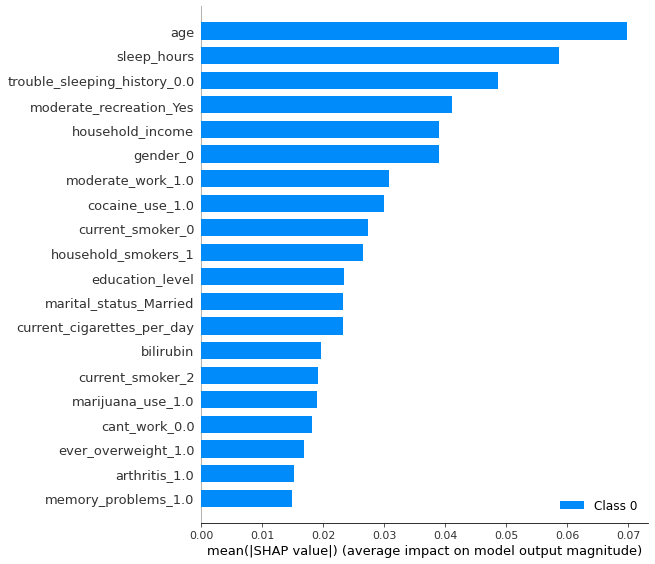

In [61]:
shap.summary_plot(shap_values,X_test,feature_names=features)

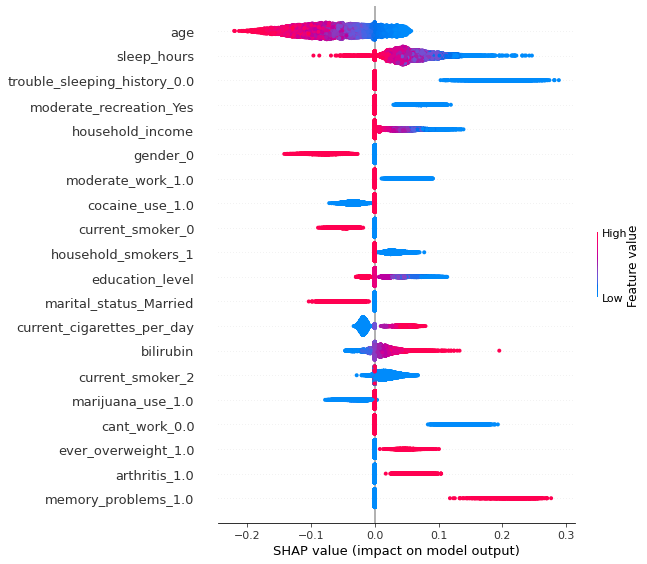

In [62]:
shap.summary_plot(shap_values[0], X_test, feature_names=features)